In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

Для работы выбран датасет содержащий информацию по добыче экспорту и внутреннему тспользованию бензина между 181 странами

In [2]:
data = pd.read_csv("Petroll.csv", )
data.set_index('Country',drop=True, inplace=True)
data.head()

,Daily Oil Consumption (Barrels),World Share,Yearly Gallons Per Capita,Price Per Gallon (USD),Price Per Liter (USD),Price Per Liter (PKR)
Country,,,,,,
United States,19687287,20.30%,934.3,5.19,1.37,289.97
China,12791553,13.20%,138.7,5.42,1.43,302.87
India,4443000,4.60%,51.4,5.05,1.33,281.93
Japan,4012877,4.10%,481.5,4.69,1.24,262.05
Russia,3631287,3.70%,383.2,3.41,0.90,190.56


получаем статистические данные по числовым столбцам такие как : среднее значениея, максимальное,  минимальное, дисперсию и несмещенное среднеквадратичное отклонение

In [3]:
new_share = [round(float(val[:-1]), 2) for val in data["World Share"].values]
World_Share = np.array(new_share, dtype=np.float32)
data["World Share"] = World_Share
def get_stats(X):
    statistic = {}    
    for col in X.columns:
        if X[col].dtype !='object'and col !='#':            
            statistic[col]={'mean':X[col].mean(),'max':X[col].max(),'min':X[col].min(),'var':X[col].var(),'std_n1':X[col].std(ddof=1)}
    stats_pd = pd.DataFrame(statistic)
    return stats_pd
get_stats(data)


,Daily Oil Consumption (Barrels),World Share,Yearly Gallons Per Capita,Price Per Gallon (USD),Price Per Liter (USD),Price Per Liter (PKR)
mean,5.335730e+05,0.550331,332.006630,5.695691,1.505138,318.219227
max,1.968729e+07,20.299999,3679.500000,54.890000,14.500000,3066.750000
min,5.100000e+01,0.000000,2.200000,0.080000,0.020000,4.650000
var,3.452413e+12,3.673084,190583.529289,19.101132,1.333043,59629.772382
std_n1,1.858067e+06,1.916529,436.558735,4.370484,1.154575,244.192081


Постоим график цены бензина за литр в долларах по странам

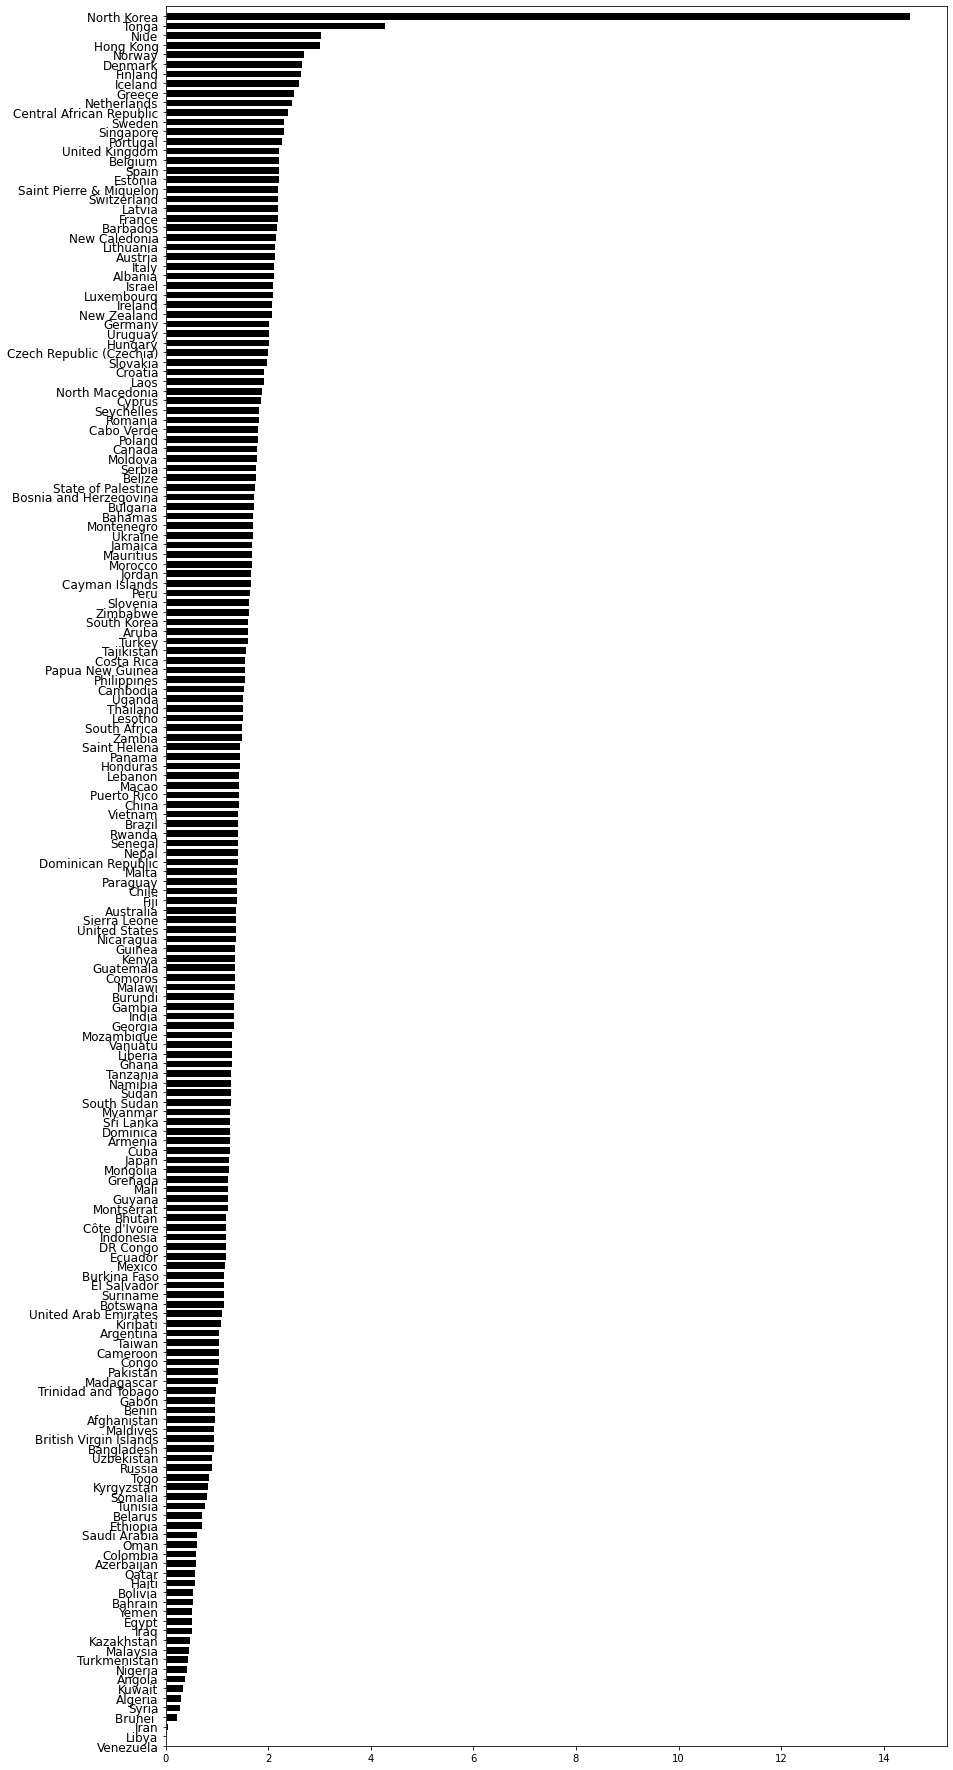

In [4]:
rcParams['figure.figsize'] = 14, 32
plt.barh(data.sort_values('Price Per Liter (USD)').index, data["Price Per Liter (USD)"].sort_values(), color='black', edgecolor='white')
plt.yticks(fontsize=12)
plt.ylim(0,data.shape[0])
plt.show()

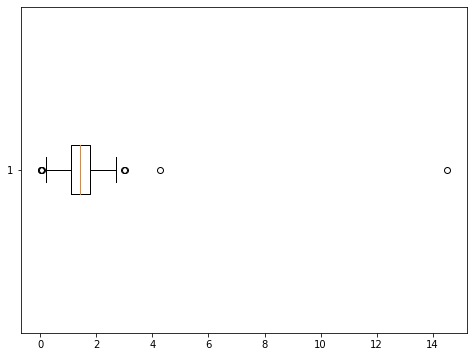

In [5]:
rcParams['figure.figsize'] = 8, 6
plt.boxplot(data["Price Per Liter (USD)"], vert=False)
plt.show()

In [6]:
Q_1 = data["Price Per Liter (USD)"].quantile(q=0.25) 
Q_3 =data["Price Per Liter (USD)"].quantile(q=0.75)
IQR = Q_3- Q_1
left_border = Q_1 - 1.5*IQR
rigth_border = Q_3 + 1.5*IQR
left_border, rigth_border
Outlier = data[(data["Price Per Liter (USD)"] < left_border) | (data["Price Per Liter (USD)"] > rigth_border)]
print(f"в итоге имем {Outlier['Price Per Liter (USD)'].count()} наблюдений выходящих за пределы интерквартильного размаха")

в итоге имем 7 наблюдений выходящих за пределы интерквартильного размаха


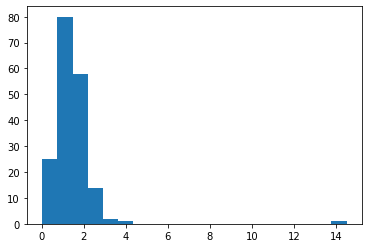

In [7]:
rcParams['figure.figsize'] = 6, 4

plt.hist(data['Price Per Liter (USD)'], bins =20)
plt.show()

Распределение цены похоже на нормалное

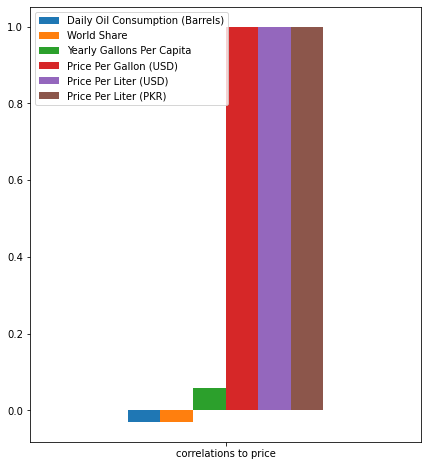

In [8]:
rcParams['figure.figsize'] = 7, 8
cor_dict= {}
for col in data.columns:     
    if data[col].dtype !='object'and col !='#':            
        cor_dict[col] =np.corrcoef(data[col], data['Price Per Liter (USD)'])[0,1]
correlations = pd.DataFrame(cor_dict,index=["correlations to price"])
correlations.plot(kind='bar', legend='Left')
plt.xticks(rotation=0)
plt.show()

Данные цен в галонах(USD) литраx(USD) и в пакистанских рупиях сильно скорелированны 

Попробуем построить  модель линейной регрессии для целевой переменной используя метод наименьших квадратов

In [9]:
data_feat = list(data.columns)
target_feat = data_feat.pop(data_feat.index('Price Per Liter (USD)'))

In [10]:
x2 = data[data_feat].values
y2 = data[target_feat].values.reshape(-1, 1)

ones = np.ones((x2.shape[0], 1))
x2 = np.hstack((ones, x2))

XTX = x2.T.dot(x2)
np.linalg.det(XTX)

3.980366536931008e+27

определитель матрицы не близок к 0, так что можем использовать аналитическую модель

In [11]:
XTX_inv = np.linalg.inv(XTX)

b = XTX_inv.dot(x2.T).dot(y2)
b0, b1, b2, b3, b4, b5 = b
z =b0 + b1*(data['Daily Oil Consumption (Barrels)']) + b2*(data['World Share']) + b3*(data['Yearly Gallons Per Capita'])\
+ b4*(data['Price Per Gallon (USD)']) + b5*(data['Price Per Liter (PKR)'])

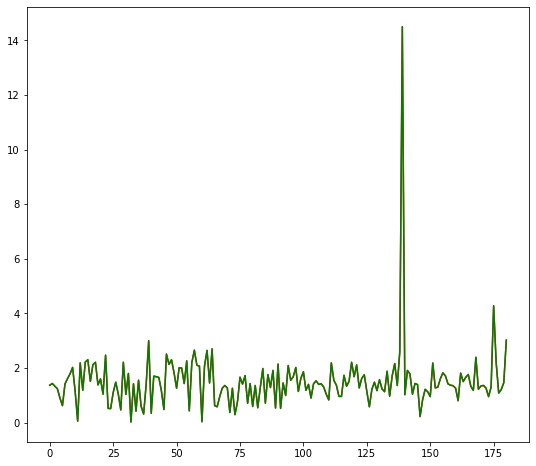

In [15]:
rcParams['figure.figsize'] = 9, 8
plt.plot(np.arange(0, data.shape[0]), data['Price Per Liter (USD)'], color ='red')
plt.plot(np.arange(0, data.shape[0]), z, color='green')
plt.show()

графики почти идентичны и можем оценить качество моджели с помощью коэфициента детерминации

In [13]:
print(f"модель описывает {100*z.var()/data['Price Per Liter (USD)'].var()} % дисперсии целевой переменной")

модель описывает 99.99943187099915 % дисперсии целевой переменной
